<a href="https://colab.research.google.com/github/BraedenKuether/Capstone/blob/MLPrototypes/portedModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
!pip install pyEX
import pyEX as p
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch import optim



In [61]:
TIME = 30
BATCHSIZE = 1

In [5]:
np.random.seed(123)
class WeightNet(nn.Module):
   def __init__(self,inputShape,numAssets):
        super(WeightNet, self).__init__()
        numFeatures = inputShape[0]-1
        self.lstm = nn.LSTM(numAssets*2,1,3,batch_first=True)
        self.lin = nn.Linear(numFeatures,numAssets)
        self.soft = nn.Softmax(dim=2)

   def forward(self, x):
        x, _ = self.lstm(x)
        #print(x.shape)
        x = x.reshape(BATCHSIZE,1,x.shape[1])
        x = self.lin(x)
        #print(x.shape)
        return self.soft(x)

In [15]:
class PortfolioModel:
  def sharpe(self,d):
    data = self.data
    pV = torch.sum(torch.multiply(data,d),axis=2)
    pR = torch.div(torch.sub(pV[:,1:],pV[:,:-1]),pV[:,:-1])
    eR = torch.div(torch.sum(pR),d.shape[0])
    sharpe = torch.div(eR,torch.std(pR))
    reg = torch.sum(d*d)
    return -sharpe + reg

  def __init__(self,inputShape,numAssets):
    self.data = None
    self.model = WeightNet(inputShape,numAssets)
    self.model = self.model.double()

  def getWeights(self,data):
    cat = []
    for x in data:
      d = pd.DataFrame(x)
      n = np.concatenate([d.values[1:], d.pct_change().values[1:]],axis=1)
      n = n[np.newaxis,:,:]
      cat.append(n)
    features = np.concatenate(cat, axis=0)
    data = data[:,1:]
    self.data = torch.tensor(data)
    X = features
    X = torch.tensor(X,dtype=torch.double)
    optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
    l = []
    for epochs in range(10):
      optimizer.zero_grad()
      out = self.model(X)
      loss = self.sharpe(out)
      #l.append(loss)
      loss.backward()
      optimizer.step()
    #plt.plot(l)
    #plt.show()
    return self.model(X).detach().numpy()

    


In [7]:
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [83]:
def fetchStockData(client, symb, interval):
  x = client.chartDF(symb,timeframe='1y')
  noWindow = x['close']
  x = rolling_window(x['close'].values,interval)
  return (x[:,:,np.newaxis],noWindow)

In [53]:
IEX_TOKEN = "Tpk_647cd93d6c5842d6978e55c6f79b0e1a"

client = p.Client(api_token = IEX_TOKEN, version='sandbox')

#stonks = ['vti', 'agg', 'dbc', 'vixy']
stonks = ['amd','wfc','ge','aapl','aal','hog','f','bac','t','intc']
NSTOCKS = len(stonks)
print(NSTOCKS)
l = []
historical = []
m = 10000000000
for s in stonks:
 d,nw = fetchStockData(client,s,TIME)
 m = min(m,len(d))
 l.append(d)
 historical.append(nw)

new = []
for s in l:
  if len(s) > m:
    new.append(s[:m])
  else:
    new.append(s)
data = np.concatenate(new,axis=2)
print(data.shape)
hist = pd.concat(historical,axis=1)
print(hist[0:1])

10
(1229, 30, 10)
            close  close    close   close  ...  close  close  close  close
date                                       ...                            
2015-12-31   2.92  56.05  31.2953  27.606  ...   14.2  16.83  35.92  35.01

[1 rows x 10 columns]


In [62]:
def eval(data,weights): 
   returnStocks = data.pct_change()
   returnStocks['pdr'] = returnStocks.dot(weights)
   print(1+returnStocks)
   cumDailyReturns = (1+returnStocks).cumprod()
   print(cumDailyReturns)
   plt.plot(cumDailyReturns['pdr'])
   plt.show()
   return cumDailyReturns['pdr'].mean()

eval(hist,[0.2, 0.3, 0.3, 0.2])

ValueError: ignored

In [96]:
def eval2(data,weights):
   #print(data.shape,weights.shape) 
   #print(data)
   returnStocks = data.pct_change()
   #print(returnStocks)
   returnStocks['pdr'] = returnStocks.dot(weights)
   #print(returnStocks)
   return (1+returnStocks)

In [98]:
def batchData(data,batchSize):
  batches = []
  i = 0
  while (i+batchSize) < data.shape[0]:
    batches.append(data[i:i+batchSize,:,:])
    i += batchSize
  return batches


#TODO: inspect this carefully the results are too good to be true
def trainAndTest(batches,batchSize):
  #BATCH SIZE X DAYS-1 X assets*2
  # 1.08110000e+02  1.10000000e+02  1.47000000e+01  2.50700000e+02
  m = PortfolioModel(batches[0].shape[1:],batches[0].shape[2])
  weights = nn.functional.softmax(torch.randn((NSTOCKS)))
  returns = [eval2(hist[0:TIME],weights)]
  batchDay = 0
  for b in batches:
    #print(b.shape)
    #print(b[-1].shape)
    if batchDay % 10 == 0:
      print(batchDay)
    if (batchDay+batchSize) % TIME == 0:
      #print("Historical")
      #print(hist[batchDay:batchDay+TIME])
      #print("Batch")
      #print(b[-1])
      returns.append(eval2(hist[batchDay:batchDay+TIME],weights))

    weights = torch.mean(torch.tensor(m.getWeights(b)),0)
    weights = weights.reshape(-1,1)
    batchDay += batchSize

  print(weights)
  print(returns)
  h = pd.concat(returns,axis=0)
  h = h.cumprod()
  plt.plot(h['pdr'])
  plt.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
tensor([[9.4596e-02],
        [2.7488e-04],
        [4.3327e-01],
        [3.9550e-02],
        [1.0170e-03],
        [6.1746e-02],
        [3.3675e-01],
        [2.3099e-02],
        [4.6113e-03],
        [5.0881e-03]], dtype=torch.float64)
[               close     close     close  ...     close     close       pdr
date                                      ...                              
2015-12-31       NaN       NaN       NaN  ...       NaN       NaN       NaN
2016-01-04  0.948630  0.9

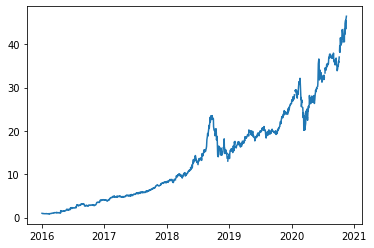

In [99]:
b = batchData(data, BATCHSIZE)
trainAndTest(b, BATCHSIZE)



